In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
import pandas as pd

# **1. Variability PK Simulation**

In [19]:
def pk_simulation(dose = 100,  
                  CL_pop = 2, 
                  V_pop = 50,
                  ka_pop = None,
                  F_pop = 1,
                  n_patients = 1, 
                  omegaCL = 0, 
                  omegaV = 0, 
                  omegaka = 0,
                  omegaF = 0,
                  C_limit = None, 
                  sampling_points = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24], 
                  logit = False):
    
    """Variability PK Simulation
    This function can be used for visualizing the PK profile of drug, using one compartment model.
    It takes into account dose, ka, ke, F, V, and CL to characterize the PK profile. It can used for modelling both IV and oral drug.
    It also take the omega arguments as the unexplained interindividual variability.
    
    Arguments: 
    dose (mg) __ float: dose
    CL_pop (L/h) __ float: estimated clearance of the population
    V_pop (L) __ float: estimated volume of distribution of the population
    ka_pop (h-1) __ float: estimated absorption constant of the population. If the ka_pop is None, the function will draw PK profile for iv drug
    F_pop __ float: estimated bioavailability of the population, in range of 0 to 1
    n_patients __ int: number of patients
    omegaCL __ float: standard deviation of the CL distribution
    omegaV __ float: standard deviation of the V distribution
    omegaka __ float: standard deviation of the ka distribution
    omegaF __ float: standard deviation of the bioavailability distribution
    C_limit (mg/L) _float: the maximum tolerated concentration
    sampling_point (h) __ list/numpy array: the time points that used for generating the concentration
    logit __ boolean: turn on/off the log(concentration)
    """
   # Reshape the time array:
    time = np.array(sampling_points).reshape(1,len(sampling_points))


    # Generate variability of PK parameters
    CV_V = norm.rvs(loc=0, scale = omegaV,size = n_patients)
    V_variability = V_pop*np.exp(CV_V)
    V_var = V_variability.reshape(n_patients,1)

    CV_CL = norm.rvs(loc=0, scale = omegaCL,size = n_patients)
    CL_variability = CL_pop*np.exp(CV_CL)
    CL_var = CL_variability.reshape(n_patients,1)


    CV_F = norm.rvs(loc=0, scale = omegaF,size = n_patients)
    F_variability = F_pop*np.exp(CV_F)
    F_var = F_variability.reshape(n_patients,1)


    ke_var = (CL_var/V_var)
    
    
    # Calculate the concentation through time
    if ka_pop == None: 
        concentration = (dose*F_var/V_var)*np.exp(np.dot(-ke_var,time))

    else:
        CV_ka = norm.rvs(loc=0, scale = omegaka,size = n_patients)
        ka_variability = ka_pop*np.exp(CV_ka)
        ka_var = ka_variability.reshape(n_patients,1)
        concentration = (dose*F_var*ka_var)/(V_var*(ka_var-ke_var))*(np.exp(np.dot(-ke_var,time))-np.exp(np.dot(-ka_var,time)))
    
    # Generate data
    df_C = pd.DataFrame(concentration, columns=sampling_points)
    df_C.replace([np.inf, -np.inf], np.nan, inplace=True)

    concentration_ln = np.log(concentration)
    df_C_ln = pd.DataFrame(concentration_ln, columns=sampling_points)
    df_C_ln.replace([np.inf, -np.inf], np.nan, inplace=True)


    # Visualization
    fig, ax = plt.subplots()
    for i in range(n_patients):
        if logit: 
            pk_data = df_C_ln.iloc[i,:]
            sns.lineplot(x=sampling_points,y=pk_data, ax=ax, color='green')
            ax.set_ylabel('Log[Concentration] (mg/L)')
            ax.set_title('PK simulation')

            if C_limit == None: 
                pass
            else: 
                plt.axhline(y=np.log(C_limit), color='r', linestyle='--')
        
        else: 
            pk_data = df_C.iloc[i,:]
            sns.lineplot(x=sampling_points,y=pk_data, ax=ax, color = 'green')
            ax.set_ylabel('Concentration (mg/L)')
            ax.set_title('PK simulation')

            if C_limit == None: 
                pass
            else: 
                plt.axhline(y=C_limit, color='r', linestyle='--')
        
        ax.set_xlabel('Time (min)')
    plt.show()
        
            

**Demo Function**

/var/folders/xg/drggnx1n5cv7mnctplfkwlzh0000gn/T/ipykernel_64527/1106651176.py:71: RuntimeWarning: divide by zero encountered in log
  concentration_ln = np.log(concentration)
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

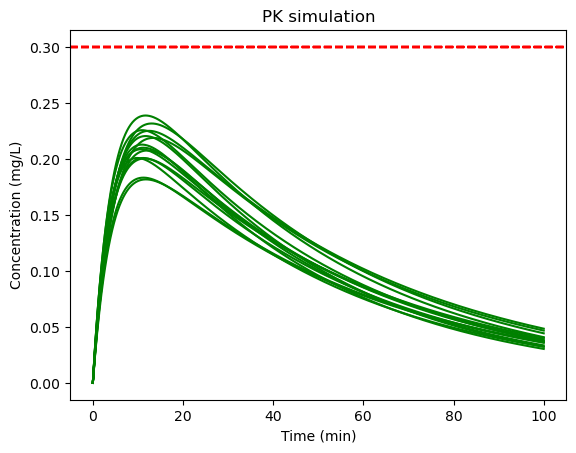

In [21]:
pk_simulation(dose = 100, 
              n_patients = 15, 
              CL_pop = 7.5, 
              V_pop = 33,
              ka_pop=0.02,
              omegaCL = 0.1, 
              omegaV = 0.1,
              omegaka=0.1,
              C_limit=0.3,
              sampling_points=np.linspace(0,100,1000),  
              logit=False)

# **2. Variability PD Simulation**

In [33]:
def pd_simulation(Emax = 6.43, 
                  EC50 = 5.38, 
                  Ebaseline = 1,
                  hill = 1, 
                  n_patients = 1,
                  omegaEmax = 0, 
                  omegaEC50 = 0, 
                  omegaEbaseline = 0, 
                  omegahill = 0,
                  E_limit = None,
                  sampling_conc = [2,4,5,6,7,8,10,20,50,100]):
    
    """Variability PD Simulation
    This function can be used for visualizing the PD profile of drug, using Emax_hill model.
    It takes into account Emax, EC50, Ebaseline, and hill to characterize the PD profile. The hill can be set to 1 to obtain the Emax model.
    It also take the omega arguments as the unexplained interindividual variability.
    
    Arguments: 
    Emax __ float: estimated maximum effect of the population. The unit is flexibly depends on the context.
    EC50 __ float: estimated half maximum effect concentration of the population. The unit is the same with concentration.
    Ebaseline __ float: estimated baseline effect of the population. The unit is flexibly depends on the context.
    hill __ float: estimated hill of the population.
    n_patients __ int: number of patients
    omegaEmax __ float: standard deviation of the Emax distribution
    omegaEC50 __ float: standard deviation of the EC50 distribution
    omegaEbaseline __ float: standard deviation of the Ebaseline distribution
    omegahill __ float: standard deviation of the hill distribution
    E_limit __ float: the effect that can lead to potential adverse effect.
    sampling_conc __ list/numpy array: the concentration that used for generating the effect
    """
    
    # Calculate CV
    Ebaseline_CV = norm.rvs(loc=0, scale = omegaEbaseline,size = n_patients)
    Emax_CV = norm.rvs(loc=0, scale = omegaEmax,size = n_patients)
    EC50_CV = norm.rvs(loc=0, scale = omegaEC50,size = n_patients)
    hill_CV = norm.rvs(loc=0, scale = omegahill,size = n_patients)

    # Calculate variability parameters 
    Ebaseline_var = (Ebaseline*np.exp(Ebaseline_CV)).reshape(n_patients,1)
    Emax_var = (Emax*np.exp(Emax_CV)).reshape(n_patients,1)
    EC50_var = (EC50*np.exp(EC50_CV)).reshape(n_patients,1)
    hill_var = (hill*np.exp(hill_CV)).reshape(n_patients,1)

    # Reshape conc
    conc_list = np.array(sampling_conc).reshape(1, len(sampling_conc))

    # Calculate E
    E_array = Ebaseline_var + Emax_var*((conc_list)**(hill_var))/(EC50_var+conc_list)
    E_df = pd.DataFrame(E_array, columns = sampling_conc)

    # Draw plot
    fig, ax = plt.subplots()
    for i in range(n_patients):
        pd_data = E_df.iloc[i,:]
        sns.lineplot(x=sampling_conc, y=pd_data, ax=ax, color='green')

    if E_limit == None: 
        pass
    else: 
        plt.axhline(y=E_limit, color='r', linestyle='--')
    
    ax.set_ylabel('Effect')
    ax.set_xlabel('Concentration')
    ax.set_title('PD simulation')
    plt.show()


/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

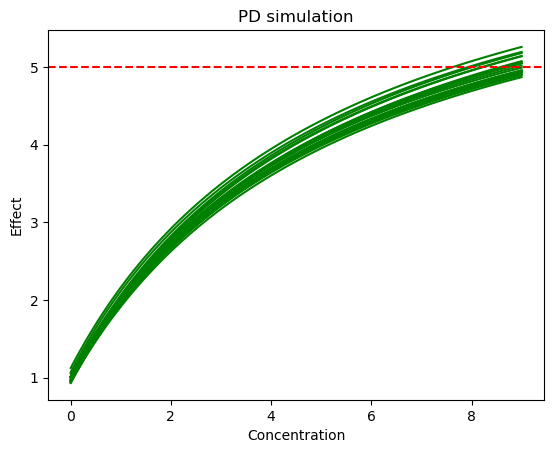

In [35]:
pd_simulation(n_patients = 20, Emax = 6.43, EC50 = 5.38, Ebaseline = 1, omegaEmax = 0.02, omegaEC50 = 0.02, omegaEbaseline = 0.05, 
              sampling_conc = np.linspace(0,9,100),E_limit=5)